### PyStan gamma-Poisson MLM example

Created 2018-01-04 by Tom Loredo for AAS231 CosPop Workshop

This notebook demonstrates the use of the Stan probabilistic programming language to implement a basic Bayesian multilevel model in a mock astronomical setting. A population of sources is modeled as having fluxes distributed according to a rolling power law (RPL, a lognormal distribution, parameterized in terms of a power law index and its rate of change).  Noisy observations are simulated, based on simple Poisson photon counting models for observations of varied exposure (and thus varied precision or signal-to-noise). The goal is to recover the population distribution (i.e., the power-law slope and its rate of change) from the observed photon counts.

This is but a caricature of what would be required in analyses of real data pertaining to the "number counts," "$\log N$&ndash;$\log S$," or "number-size distribution" of a population.  Most notably, there is no detection threshold, and thus no accounting for selection effects (which are thus absent in the simulations).  It is meant only as a simple demonstration of the potential of Stan and other probabilistic languages for astronomical data analysis.

The notebook was developed using the following tools:
* Anaconda Python 3.6.3 ([install Anaconda](http://docs.continuum.io/anaconda/install)), which includes the standard PyData packages (NumPy, SciPy, matplotlib, etc.)
* Jupyter 4.3.0 (included in recent Anaconda installations)
* PyStan 2.17 (install using `conda`, which will install optimized C/C++ compilers for macOS/Linux)

It also uses two supporting Python modules:
* `util`
* `stanfitter`

The `util` module provides a helper function to produce a simple parallel coordinates plot depicting shrinkage of flux estimates. "Shrinkage" is a technical term in multivariate statistics, referring to an effect related to what astronomers know as correction for Eddington bias. The module also includes functions for tracking and restoring NumPy's RNG state.

The `stanfitter` module provides a more "Pythonic" wrapper around PyStan's interface to Stan.  It is being maintained separately on GitHub (see [`stanfitter` on GitHub](https://github.com/tloredo/stanfitter)).  The current version is provided alongside this notebook for convenience. It is not well documented (I've been using it in the classroom, teaching its use interactively in lab sessions). Documentation is forthcoming, but this notebook illustrates key capability by example.

For information about PyStan and the Stan language, visit:

https://pystan.readthedocs.org/en/latest/getting_started.html

## Setup

In [1]:
import numpy as np
import scipy
from scipy import stats
import matplotlib as mpl

# Pollute the namespace!
from matplotlib.pyplot import *
from scipy import *

from stanfitter import StanFitter
from util import save_rng, restore_rng, shrinkage_plot

In [2]:
# Get TL's interactive plotting customizations if availalbe.  These mainly
# adjust figure and annotation sizes.
try:
    import myplot
    from myplot import close_all, csavefig
    # myplot.tex_on()
    csavefig.save = False
except:
    pass

# ion()  # use this if running as a script

In [3]:
%matplotlib inline

In [4]:
# Track Python's RNG state to enable reproducing simulated data.
# This does *not* directly track PyStan's RNG state.

# Set the following to False to generate new data, True to restore
# the RNG to a previously-saved state.
reuse_rng = True
if reuse_rng:
    # A run with data producing an excellent estimate:
    restore_rng('numpy_rng_state-LNP-beta_p25-good.pkl')
    
    # More of an edge case, though still good flux est. performance:
    # restore_rng('numpy_rng_state-LNP-beta_p25-edge.pkl')
else:
    restore_rng()

Recovered RNG state:  MT19937 [283015528 707809488 ...] 296


## Stan code for a lognormal-Poisson MLM

Stan is a sophisticated computing language. When used via PyStan, Stan code may be included in a string (as in the next cell), or in a separate file. This notebook's repo includes a file, "lognormal-poisson.stan", that shows what a Stan file looks like (it's just the string below, in a file of its own); it is not used by this notebook.

Note the use of **transformed parameters** to relate the RPL parameters to Stan's lognormal distribution parameters.  Also, Stan language constraints lead to formulation of the model using an `nbeta` parameter, the negative of the RPL $\beta$ parameter. Note the use of **generated quantities** to direct Stan to output the value of $\beta$ (in addition to `nbeta`).

In [5]:
# Stan code defining a log-normal-Poisson MLM for number counts (log N - log S)
# fitting:
code = """
data {
    int<lower = 0> N; 
    int<lower = 0> counts[N];  // photon counts from sources
    real exposure;
    real nu;  // expected contamination counts
} 

parameters {
    real alpha;  // power law index at fiducial flux=1
    real<lower = 0> nbeta;  // neg. rate of change of index wrt log flux
    real<lower = 0> fluxes[N];
}

transformed parameters {
    real mu;  // mean of log(flux)
    real<lower = 0> sigma;  // std dev'n of log(flux)

    sigma = sqrt(1./nbeta);
    mu = sigma^2 * (alpha + 1.);
}

model {
    alpha ~ cauchy(0., 1.);
    nbeta ~ exponential(1.0);
    for (i in 1:N){
        fluxes[i] ~ lognormal(mu, sigma);
        counts[i] ~ poisson(fluxes[i] * exposure + nu);
  }
}

generated quantities {
    real<upper = 0> beta;  // rate of change of index wrt log flux

    beta = -nbeta;
}
"""

## Survey description

We define a class describing a simple photon counting survey, and make an instance defining the survey we'll use for simulations.  We implement it here in terms of a dimensional flux $f = F/F_0$, where $F_0$ is some fiducial flux.  We discuss this setup in more detail in a companion notebook.

In [6]:
class PhotonCountingSurvey:

    def __init__(self, k_th, nu, expo):
        """
        Set the parameters defining the survey.

        k_th:  Specify a detection threshold to be k_th std dev'ns
        nu:    The expected number of contaminating counts in an
               exposure (from backgrounds, readout noise, etc.)
        expo:  Exposure (in dimensionless units)
        """
        self.k = k_th
        self.nu = nu
        self.expo = expo

        self.n_th = k_th**2 * (0.5 + 0.5*sqrt(1. + 4.*nu/k_th**2))**2

    def ecounts(self, f):
        """
        Compute the expected counts for a source with dimensionless flux f.
        """
        return self.expo*f + self.nu

    def f_est(self, n):
        """
        Compute a (dimensionless) flux estimate, given the number of observed
        photons, n.
        
        Returns an array of: (f_hat, sig_f).
        """
        f_hat = asarray((n - self.nu)/self.expo)
        sig_f = asarray(sqrt(n)/self.expo)
        return stack((f_hat, sig_f), axis=-1)

    def eta(self, f):
        """
        Detection efficiency for sources with dimensionless flux f.
        """
        return gammainc(self.n_th+1., self.expo*f + self.nu)

In [7]:
# Constants for the survey:
k = 4.  # k-sigma threshold; we don't actually use a threshold here
nu = 9.373  # expected background contribution
expo = (32 - nu)/0.1  # makes expected counts = n_th for f = F/F_0 = 0.1
# expo = (32 - nu)/0.3  # makes expected counts = n_th for f = F/F_0 = 0.3

survey = PhotonCountingSurvey(k, nu, expo)

## Define a population and sample source fluxes from it

We define a class implementing the RPL using SciPy's `lognormal` (which has a somewhat strange parameterization, different from Stan's), and instantiate it to get a set of (true) fluxes for the simulation.

In [8]:
class RollingPowerLaw:
    """
    A distribution with a linearly rolling power law index---a
    reparameterization of a log-normal distribution.
    """

    def __init__(self, alpha, beta):
        """
        Initialize a rolling power law with index `alpha` at argument x=1,
        and with the derivative of the index given by `beta` (< 0).
        """
        self.alpha, self.beta = alpha, beta

        # Derived params for lognormal:
        self.sig = 1./sqrt(-beta)
        self.mu = self.sig**2 * (alpha + 1.)

        # SciPy's funky scale param;
        # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
        emu = exp(self.mu)

        # sig is the shape parameter.
        self.distn = stats.lognorm(self.sig, scale=emu)

    def pdf(self, x):
        return self.distn.pdf(x)

    def sample(self, size=None, rng_state=None):
        return self.distn.rvs(size, rng_state)

In [9]:
# Population for simulating data:
alpha, beta = -1.5, -0.25  # fiducial index, roll rate
popn = RollingPowerLaw(alpha, beta)

# Sample some source fluxes from the flux population dist'n.
n_s = 100  # sample size
fluxes = popn.sample(n_s)

## Simulate data

We simulate a Poisson datum for each source flux.  The data are gathered in a Python dict, as required by PyStan.

In [10]:
def gen_data(fluxes, survey):
    """
    Simulate photon count data from the Poisson distribution, gathering
    the data and descriptive information in a dict as needed by Stan.
    """
    n_exp = survey.ecounts(fluxes)  # expected counts for each source
    counts = stats.poisson.rvs(n_exp)
    return dict(N=len(fluxes), exposure=survey.expo, nu=survey.nu,
                counts=counts)

data = gen_data(fluxes, survey)

## Invoke Stan to build the model

Invoke Stan via the StanFitter class. It takes Stan code either as a string (as here), or via a file.

Stan will "write" and compile a C++ executable implementing the model, a
posterior sampler, Markov chain output analysis functions, and an optimizer.
This takes a bit of time. StanFitter will cache the Stan products so
subsequent runs of the script need not rebuild the model from scratch.

**NOTE:** PyStan's compilation and simulation progress will be reported on the `stderr` stream, which Jupyter notebooks print to the console session hosting the session. **When using PyStan, make sure you check your Jupyter session's console window for progress reports and warnings.** If Stan has trouble, you likely won't see any activity in the notebook indicating there was a problem. In particular, if there's a bug in the Stan code, the error message will appear on the console, not in the notebook.

In [11]:
# Use the code string in this notebook (above); StanFitter also supports 
# code in external files.
fitter = StanFitter(code, data) 

Using cached StanModel from cached-model-Anon-732d680ca87046942432abe58492ff22.pkl...


## Do MCMC posterior sampling via Hamiltonian Monte Carlo

A `StanFitter` instance has a `sample()` method that invokes Stan's default HMC "No-U-Turn Sampler" (NUTS). It returns a `Fit` object providing access to many results of the sampling run.

Remember, *progress is logged to the console window*.

In [12]:
# Run 4 chains of length 2000 (Stan will use 1/2 of each for burn-in).
fit = fitter.sample(8000, 4)

### Quick summary

Print a quick textual summary of the MCMC results for all parameters and
the log posterior density, log_p.  For the vector parameter, `fluxes`, a
summary is printed for *every* element, which may not be desired if there
are many such parameters.

In [13]:
print(fit)

Inference for Stan model: anon_model_732d680ca87046942432abe58492ff22.
4 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -1.55  7.9e-4    0.1  -1.77  -1.62  -1.55  -1.48  -1.37  16000    1.0
nbeta        0.27  4.5e-4   0.05   0.19   0.24   0.27    0.3   0.37  10345    1.0
fluxes[0]    0.12  2.1e-4   0.03   0.08   0.11   0.12   0.14   0.18  16000    1.0
fluxes[1]  8.6e-3  5.8e-5 7.4e-3 5.6e-4 3.2e-3 6.6e-3   0.01   0.03  16000    1.0
fluxes[2]    0.12  2.1e-4   0.03   0.07    0.1   0.11   0.13   0.17  16000    1.0
fluxes[3]  8.7e-3  6.0e-5 7.5e-3 5.0e-4 3.2e-3 6.6e-3   0.01   0.03  16000    1.0
fluxes[4]  8.5e-3  5.8e-5 7.3e-3 5.2e-4 3.1e-3 6.5e-3   0.01   0.03  16000    1.0
fluxes[5]    0.82  4.9e-4   0.06   0.71   0.78   0.82   0.86   0.95  16000    1.0
fluxes[6]     7.6  1.5e-3   0.19   7.23   7.47   7.59   7.72   7.96  160

### Check convergence and mixing of chains

After sampling, the `fit` object has attributes for each parameter and
transformed parameter in the model; the attributes provide access to
the chains (4 chains in this case), a pooled and thinned collection of samples from all chains, and
various summary statistics for each parameter (including MCMC output
diagnostics).

Verify convergence by looking at the Gelman-Rubin $\hat R$ statistic for every
parameter of interest; it should be within a few % of 1. Also, examine the effective sample size (ESS) as a first indication of how well the post-burn-in chains are mixing. As a rule of thumb, if you aim to report 95% credible regions for parameters, you want the ESS to be at least a few thousand.

**Pontification:** Too many Bayesian analyses in the astronomical literature fail to describe adequate MCMC output analysis (most likely because the authors failed to *do* adequate output analysis). For brevity, this notebook presents the *bare minimum* of what you should be doing. If your problem requires MCMC, then it also requires you to really learn about how to do MCMC right. A good starting point is this standard reference:

* *Handbook of Markov Chain Monte Carlo* ([authors' web site](http://www.mcmchandbook.net/HandbookTableofContents.html), [publisher's web site](https://www.crcpress.com/Handbook-of-Markov-Chain-Monte-Carlo/Brooks-Gelman-Jones-Meng/9781420079418))

Note that some of the key chapters are *freely available* at the authors' web site. Don't 
use MCMC methods unless you've at least read Charlie Geyer's ["Introduction to MCMC"](http://www.mcmchandbook.net/HandbookChapter1.pdf), esp. section 1.11 on "The Practice of MCMC." Not all experts practitioners agree with all of Geyer's advice (particularly in regard to whether it's better to run a few parallel chains or one long chain), but the vast majority of his recommendations and insights are shared by experts. Some notable excerpts, to motivate you:

> There is a great deal of theory about convergence of Markov chains. Unfortunately, none
of it can be applied to get useful convergence information for most MCMC applications.
Thus most users find themselves in the... situation we call *black box MCMC*....

> When you are in the black box situation, you have no idea how long runs need to be to
get good mixing (convergence rather than pseudo-convergence)....

> Your humble author has a dictum that the least one can do is to make an overnight run.
What better way for your computer to spend its time? In many problems that are not too
complicated, this is millions or billions of iterations. If you do not make runs like that, you
are simply not serious about MCMC. Your humble author has another dictum (only slightly
facetious) that one should start a run when the paper is submitted and keep running until the
referees’ reports arrive. This cannot delay the paper, and may detect pseudo-convergence.

The [PyMC](https://pymc-devs.github.io/pymc/) package provides several tools for MCMC output analysis. Two R packages that statisticians have developed for MCMC output analysis are [`coda`](https://cran.r-project.org/web/packages/coda/index.html) and [`BOA`](http://www.public-health.uiowa.edu/boa/). You may be able to acess them from Python via [`RPy2`](http://rpy.sourceforge.net/) (note that Anaconda has an R channel, providing support for R and RStudio in conda environments).

In [14]:
# For scalar params, just make a table of Rhat and ESS.
scalars = [fit.alpha, fit.beta]
print('*** Checks for convergence, mixing ***')
print('Rhat, ESS for scalar params:')
for param in scalars:
    print('    {0:12s}:  {1:6.3f}  {2:6.0f}'.format(param.name, param.Rhat, param.ess))

*** Checks for convergence, mixing ***
Rhat, ESS for scalar params:
    alpha       :   1.000   16000
    beta        :   1.000   10345


Rhat range for fluxes: 0.999767411954 1.00010547148
ESS range for fluxes:  16000.0 16000.0


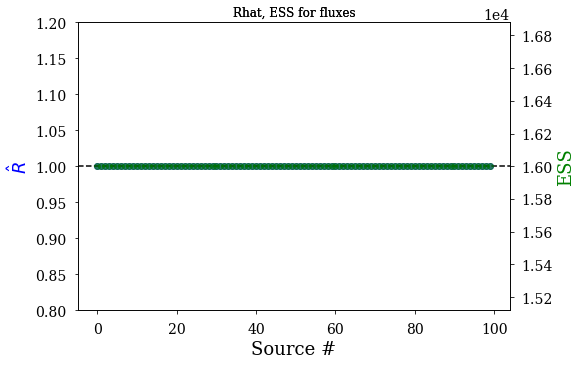

In [15]:
# For the vector of latent fluxes, make a plot.
flux_Rhats = array([fit.fluxes[i].Rhat for i in range(n_s)])
figure(figsize=(8,5))
subplots_adjust(top=.925, right=.875)  # make room for title, right ESS labels
ax_left = subplot(111)  # left axis for Rhat
plot(range(n_s), flux_Rhats, 'ob', alpha=.6)
ylim(0.8, 1.2)
axhline(y=1., ls='--', color='k')
title('Rhat, ESS for fluxes')
xlabel('Source #')
ylabel(r'$\hat R$', color='b')
ax_right = twinx()  # right axis for ESS
flux_ess = array([fit.fluxes[i].ess for i in range(n_s)])
plot(range(n_s), flux_ess, 'og', alpha=.6)
title('Rhat, ESS for fluxes')
ylabel('ESS', color='g')
print('Rhat range for fluxes:', flux_Rhats.min(), flux_Rhats.max())
print('ESS range for fluxes: ', flux_ess.min(), flux_ess.max())

### Check mixing of chains

Check mixing further by examining trace plots of parameters of interest,
making sure there are no obvious trends or strong, long-range correlations.
Here we look at the scalars `alpha` and `beta` (Stan actually used `nbeta` in the simulation, but we only care about `beta`). Another common diagnostic (skipped here) is to examine the autocorrelation functions of traces (in fact, these can be used to compute an ESS).

/Users/loredo/anaconda/envs/cospop18/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


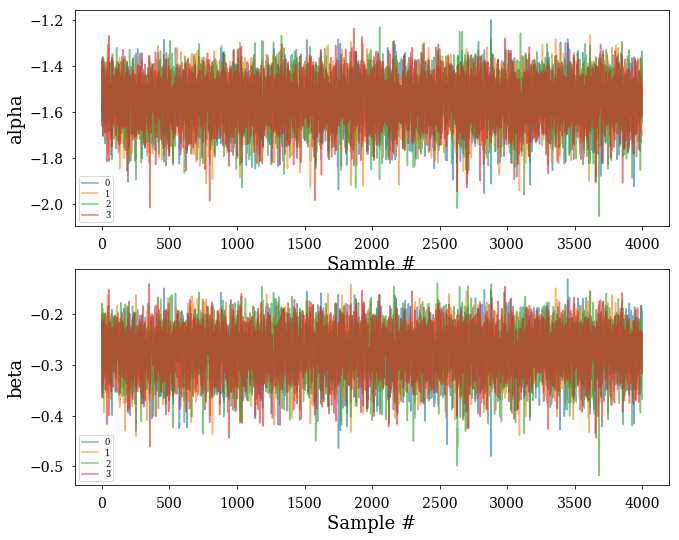

In [16]:
# Plot traces of scalar parameters; distinguish the 4 parallel chains by color.
f=figure(figsize=(10,8))
ax=f.add_subplot(2,1,1)
fit.alpha.trace(axes=ax,alpha=.6)  # without `axes`, this will make its own fig
ax=f.add_subplot(2,1,2)
fit.beta.trace(axes=ax,alpha=.6)

/Users/loredo/anaconda/envs/cospop18/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


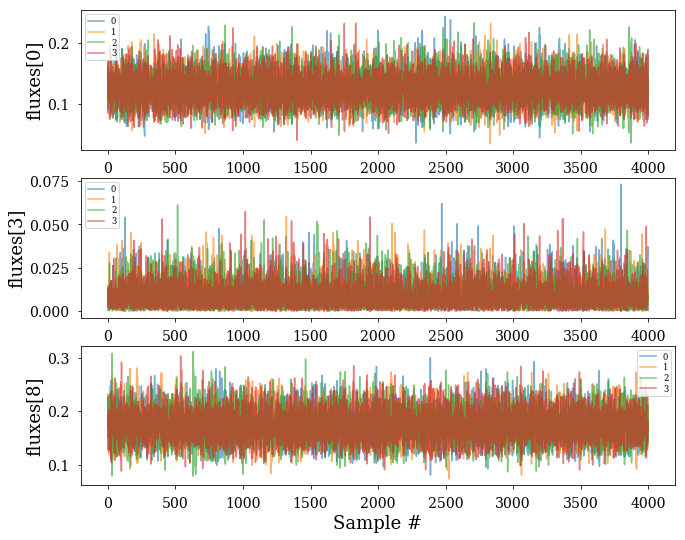

In [17]:
# Look at traces for some fluxes.
f=figure(figsize=(10,8))
ax=f.add_subplot(3,1,1)
fit.fluxes[0].trace(axes=ax,alpha=.6)
ax=f.add_subplot(3,1,2)
fit.fluxes[3].trace(axes=ax,alpha=.6)
ax=f.add_subplot(3,1,3)
fit.fluxes[8].trace(axes=ax,alpha=.6)

/Users/loredo/anaconda/envs/cospop18/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


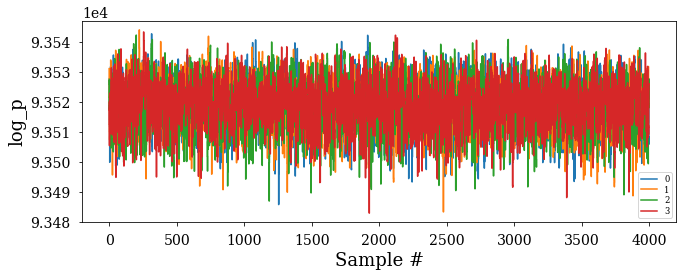

In [18]:
# Look at the log_p trace plot.
fit.log_p.trace()  # creates a new fig by default

## Inferences

Now, **after** the checks, we're ready to make some inferences.

Show the joint distribution for (`alpha`, `beta`) as a scatterplot, and
marginals as histograms.

Text(0,0.5,'$p(\\beta|D)$')

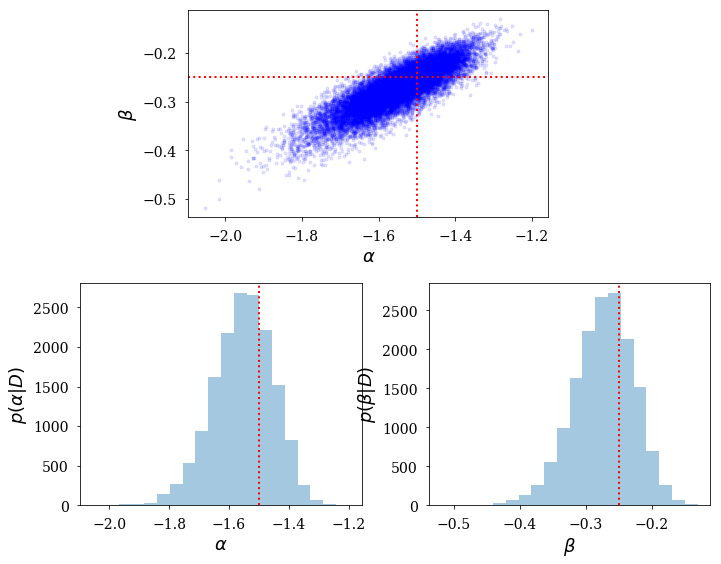

In [19]:
f = figure(figsize=(10,8))
subplots_adjust(bottom=.1, left=.1, right=.975, wspace=.24, )

# subplot(232)  # joint at mid-top
f.add_axes([.25, .6, .5, .36])
plot(fit.alpha.thinned, fit.beta.thinned, 'b.', alpha=.1)
# crosshair showing true values:
xhair = { 'color' : 'r', 'linestyle' : ':' , 'linewidth' : 2}
axvline(alpha, **xhair)
axhline(beta, **xhair)
xlabel(r'$\alpha$')
ylabel(r'$\beta$')

subplot(223)  # marginal for alpha bottom-left
hist(fit.alpha.thinned, 20, alpha=.4)
axvline(alpha, **xhair)
xlabel(r'$\alpha$')
ylabel(r'$p(\alpha|D)$')

subplot(224)  # marginal for beta bottom-right
hist(fit.beta.thinned, 20, alpha=.4)
axvline(beta, **xhair)
xlabel(r'$\beta$')
ylabel(r'$p(\beta|D)$')

Make a plot illustrating shrinkage of point estimates for the fluxes. The shrinkage is pretty minimal for bright fluxes (as one would expect), but significant for those with the noisiest measurements (some noisy cases may have ML estimates that fall out of bounds in the plot).


(alpha,beta) for highest PDF sample: -1.78  -0.38



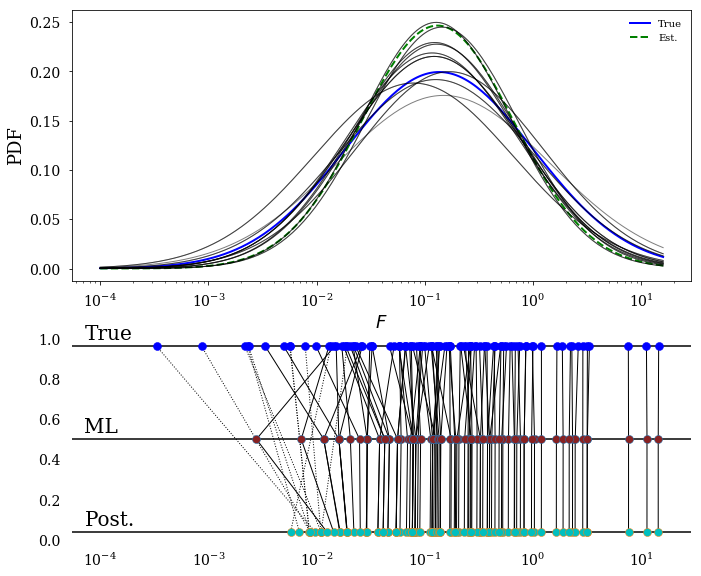

In [20]:
# Max likelihood estimates:
# F_ml = data['counts']/data['exposures']
MLEs = survey.f_est(data['counts'])
F_ml = MLEs[:,0]
sig_ml = MLEs[:,1]

# Means of marginal posteriors:
F_post = array([fit.fluxes[i].mean for i in range(n_s)])
sig_post = array([fit.fluxes[i].sd for i in range(n_s)])
u = 1.1*fluxes.max()
F_vals = logspace(-4, log10(u), 200)  # fluxes for PDF plot
pdf_vals = popn.pdf(F_vals)  # true number-size dist'n over F_vals
ax_pdf, ax_pts = shrinkage_plot(F_vals, pdf_vals, fluxes, F_ml, F_post, r'$F$',
                 log_x=True, log_y=False)

# Get a 'best fit' set of parameters by finding the sample with highest
# posterior density; this would be a bad idea in high dimensions (use Stan's
# optimizer in such cases).
i = fit.log_p.thinned.argmax()
a, b = fit.alpha.thinned[i], fit.beta.thinned[i]
print('\n(alpha,beta) for highest PDF sample: {:.2f}  {:.2f}\n'.format(a,b))

# Plot the PDF for the best-fit model.
best = RollingPowerLaw(a, b)
ax_pdf.semilogx(F_vals, F_vals*best.pdf(F_vals), 'g--', lw=2, label='Est.')
ax_pdf.legend(frameon=False)

# Show the PDFs for some posterior samples.
for i in 49*linspace(1,10,20,dtype=int):  # every 49th sample
    a, b = fit.alpha.thinned[i], fit.beta.thinned[i]
    distn = RollingPowerLaw(a, b)
    ax_pdf.semilogx(F_vals, F_vals*distn.pdf(F_vals), 'k', lw=1, alpha=.5, label=None)

Examine the performance of the flux point estimators: maximum likelihood and (marginal) posterior mean. These are a poor summary of the flux estimation, but as an ensemble they tell us something about the shrinkage happening in the model.

In [21]:
# A helper function, so we can compare performance in various subsets of the data.

def compare_pt(fluxes, F_ml, sig_ml, F_post, sig_post):
    """
    Compare point estimator performance.
    """
    # Mean relative errors for ML vs. posterior means:
    mre_ml = sum(abs(F_ml - fluxes)/fluxes)/n_s
    mre_post = sum(abs(F_post - fluxes)/fluxes)/n_s
    print('* Mean relative abs. flux errors:', 
        '{:.3f}  {:.3f}'.format(mre_ml, mre_post))

    # RMS relative errors for ML vs. posterior means:
    rms_ml = sqrt(sum( ((F_ml - fluxes)/fluxes)**2 )/n_s)
    rms_pm = sqrt(sum( ((F_post - fluxes)/fluxes)**2 )/n_s)
    print('* RMS relative flux errors:',
        '{:.3f}  {:.3f}'.format(rms_ml, rms_pm))

    # RMS weighted errors for ML vs. posterior means:
    rms_ml = sqrt(sum( ((F_ml - fluxes)/sig_ml)**2 )/n_s)
    rms_pm = sqrt(sum( ((F_post - fluxes)/sig_post)**2 )/n_s)
    print('* RMS weighted flux errors:',
        '{:.3f}  {:.3f}'.format(rms_ml, rms_pm))
    # Ignoring correlations, this is like chi**2/n_s:
    print('  (should be unity to ~ {:.2f})'.format(sqrt(2/n_s)))

In [22]:
# Compare across the whole sample.

print('\n\nPoint estimate performance, MLEs vs posterior means:\n')
compare_pt(fluxes, F_ml, sig_ml, F_post, sig_post)

# Compare again, discarding very weak sources for which the comparison
# statistics are not meaningful.
ranked = fluxes[fluxes.argsort()]
f_cut = ranked[int(0.05*n_s)]
non_dim = fluxes > f_cut
nx = n_s - sum(non_dim)
print('\n\nPoint estimate performance excluding dimmest 5%:\n')
compare_pt(fluxes[non_dim], F_ml[non_dim], sig_ml[non_dim],
    F_post[non_dim], sig_post[non_dim])



Point estimate performance, MLEs vs posterior means:

* Mean relative abs. flux errors: 0.843  0.731
* RMS relative flux errors: 2.675  3.057
* RMS weighted flux errors: 1.046  0.863
  (should be unity to ~ 0.14)


Point estimate performance excluding dimmest 5%:

* Mean relative abs. flux errors: 0.329  0.233
* RMS relative flux errors: 0.686  0.460
* RMS weighted flux errors: 1.009  0.829
  (should be unity to ~ 0.14)


Make a plot displaying the flux errors associated with the point estimates.

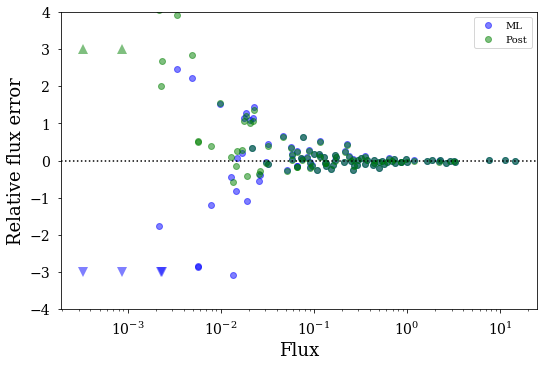

In [23]:
# Plot relative absolute errors.  Mark large deviations separately.
f = figure(figsize=(8,5))
r = (F_ml - fluxes)/fluxes
semilogx(fluxes, r, 'bo', alpha=.5, label='ML')
out = r > 5.
y = 3.*ones_like(fluxes[out])
semilogx(fluxes[out], y, 'b^', ms=10, mew=0, alpha=.5)
out = r < -5.
y = -3.*ones_like(fluxes[out])
semilogx(fluxes[out], y, 'bv', ms=10, mew=0, alpha=.5)

r = (F_post - fluxes)/fluxes
semilogx(fluxes, r, 'go', alpha=.5, label='Post')
out = r > 5.
y = 3.*ones_like(fluxes[out])
semilogx(fluxes[out], y, 'g^', ms=10, mew=0, alpha=.5)
out = r < -5.
y = -3.*ones_like(fluxes[out])
semilogx(fluxes[out], y, 'gv', ms=10, mew=0, alpha=.5)

axhline(0, ls=':', c='k')
xlabel('Flux')
ylabel('Relative flux error')
ylim(-4., 4.)
legend()

In [24]:
# Save current RNG state so the RNG sequence can continue on later runs.
save_rng()